In [ ]:
# 인용 : https://www.kaggle.com/asindico/customer-segments-with-pca
# 참조 : https://www.kaggle.com/mgabrielkerr/visualizing-knn-svm-and-xgboost-on-iris-dataset

+ **목적** : 구매이력 기반, 유의미한 그룹 분류
+ **방법** : Factor Analysis 통한 차원축소 (6차원) 후, k-means (3-group)
+ **대상** : 19.09 구매회원 기준  
---  
+ **결론**
  + 그룹분류
    + 전체 : 라떼 선호 / 룽고 선호 /  S 사이즈 선호 
    + 임직원 : 아침식사 / 음료&제빵 / 주스류 구매
  + 기타 : 차원 선택 문제는 발생하지 않음

In [28]:
#######
# import
###

import cx_Oracle as oci
import pandas as pd

from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
#######
#1. 자료추출(Oracel SQL)
###

## DB 접속
conn = oci.connect('*******************************************')

## query 실행( =자료 추출)
df_all = pd.read_sql("select S.stor_cd || S.pos_no || S.bill_no as order_no, S.Item_cd, S.sale_qty " + 
                     ", S.CUST_id "
                     "from sale_dt S, item I, c_cust C " +
                     "where S.sale_dt between '20190901' and '20190930' " +
                     "and S.item_cd = I.item_cd(+) " +
                     "and cust_stat <> 9 " +
                     "and C.cust_id = S.cust_id " +
                     "and S.t_seq = 0 " +
                     "and S.CUST_id is not null "
                      , con = conn )

## DB 접속종료
conn.close()

In [3]:
### 자료확인
df_all.head(3)

,ORDER_NO,ITEM_CD,SALE_QTY,CUST_ID
0,20000880100003,179549,1,!junie77
1,20000880100011,271028,1,!junie77
2,20000880100011,170157,1,!junie77


In [4]:
## pivot
cust_prod = pd.crosstab(df_all['CUST_ID'], df_all['ITEM_CD'])
cust_prod.head(5)

ITEM_CD,170039,170040,170048,170050,170052,170054,170055,170056,170058,170059,...,271036,271037,320005,320008,320022,320081,320084,320111,320117,320119
CUST_ID,,,,,,,,,,,,,,,,,,,,,
!junie77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!kby3831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#chrismh92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.??.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008051,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# t-SNE(요인분석)
tsne = TSNE(learning_rate=100)
tSNE_samples = tsne.fit_transform(cust_prod)

# Factor Analysis(요인분석) : DataFrame
# ps = pd.DataFrame(FA_samples)

In [ ]:
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=labels)


In [6]:
ps.head(5)

,0,1,2,3,4,5
0,-0.005787,-0.056566,-0.021178,-0.077389,-0.144526,0.140038
1,-0.005787,-0.060196,-0.024419,-0.137919,-0.154402,0.059107
2,-0.005787,-0.068730,-0.021898,-0.177991,-0.257238,0.313845
3,-0.005787,-0.065306,-0.018043,-0.123527,-0.151521,0.010671
4,-0.005787,-0.068351,-0.020803,-0.168944,-0.250085,0.269211


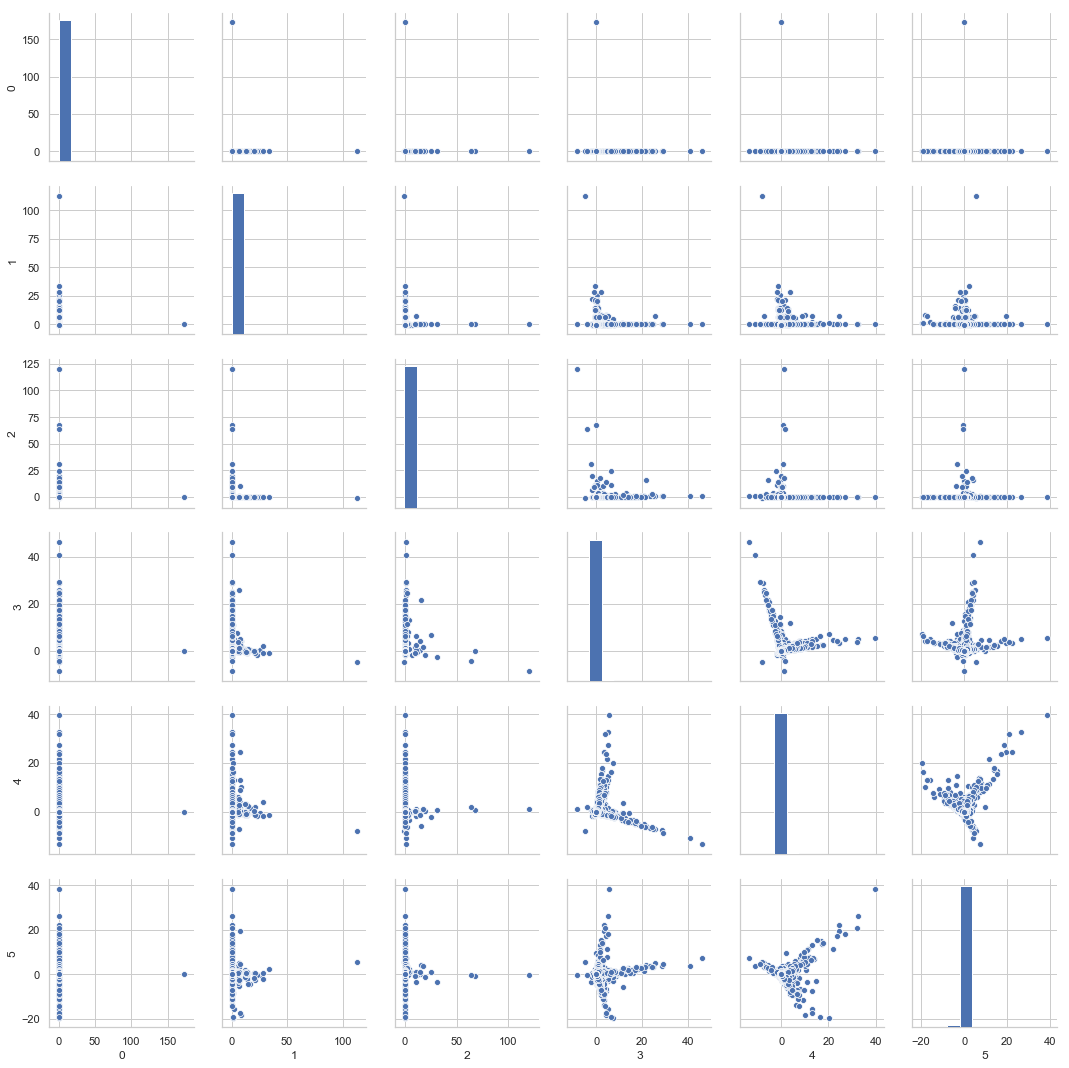

In [16]:
sns.pairplot(ps)
plt.show()

['green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green']


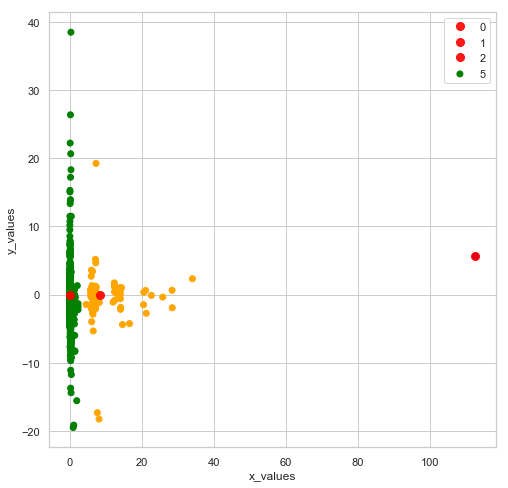

In [22]:
tocluster = pd.DataFrame(ps[[1,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]슨
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [24]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [25]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
270700,1.263804
170157,0.865031
270959,0.754601
170080,0.613497
170155,0.576687
170054,0.527607
270958,0.472393
179437,0.312883
179549,0.306748


In [27]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170155,17.0
270700,16.0
270959,16.0
179710,3.0
179159,2.0
179164,2.0
179466,1.0
179796,1.0
271028,1.0


In [26]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.396855
179549,0.230666
170155,0.228511
170080,0.228376
179437,0.209724
170134,0.169388
179438,0.153934
170039,0.141342
170054,0.131309


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


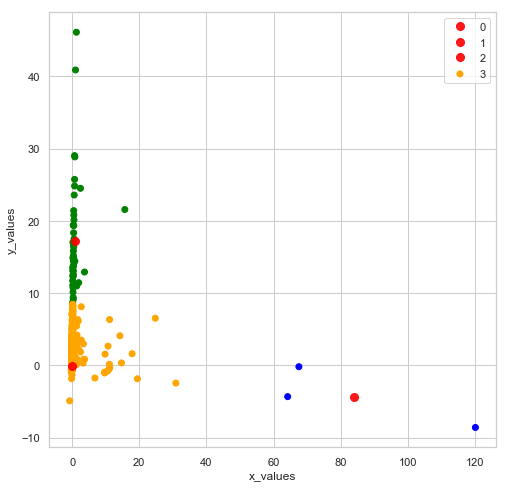

In [7]:
tocluster = pd.DataFrame(ps[[2,3]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[2],tocluster[3],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [8]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [9]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.399846
170155,0.231234
179549,0.231099
170080,0.230362
179437,0.210639
170134,0.168914
179438,0.154391
170039,0.141947
170054,0.132119


In [10]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170103,6.000000
179798,3.333333
170173,2.000000
179847,1.000000
179499,0.666667
179851,0.666667
179835,0.666667
270238,0.666667
179703,0.666667


In [11]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179797,2.791667
170105,1.979167
170054,0.979167
179854,0.604167
170134,0.583333
179799,0.583333
170175,0.541667
179548,0.500000
179846,0.458333


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


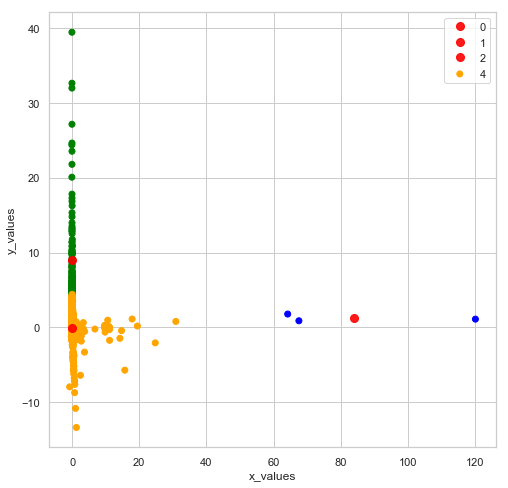

In [12]:
tocluster = pd.DataFrame(ps[[2,4]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[2],tocluster[4],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [13]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [14]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.396247
170080,0.229098
170155,0.228930
179549,0.226475
179437,0.208751
170134,0.164963
179438,0.153326
170039,0.141656
170054,0.132273


In [15]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170103,6.000000
179798,3.333333
170173,2.000000
179847,1.000000
179499,0.666667
179851,0.666667
179835,0.666667
270238,0.666667
179703,0.666667


In [16]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179549,1.304688
170134,1.242188
170157,1.132812
170155,0.710938
271025,0.695312
179437,0.570312
179333,0.570312
270591,0.562500
170080,0.546875


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


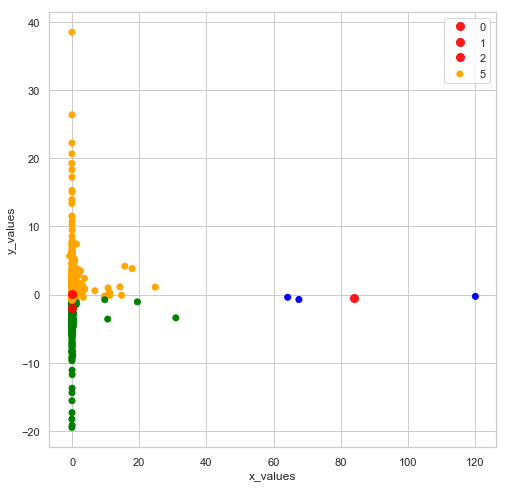

In [17]:
tocluster = pd.DataFrame(ps[[2,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[2],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [18]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [19]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.370887
170155,0.211412
170080,0.201451
179437,0.199637
179549,0.197218
179438,0.145779
170134,0.135356
170039,0.129985
170132,0.110989


In [20]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170103,6.000000
179798,3.333333
170173,2.000000
179847,1.000000
179499,0.666667
179851,0.666667
179835,0.666667
270238,0.666667
179703,0.666667


In [21]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.857224
179549,0.774986
170054,0.734437
170134,0.719018
170080,0.696174
170155,0.545403
179548,0.473444
170132,0.418618
270591,0.404911


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


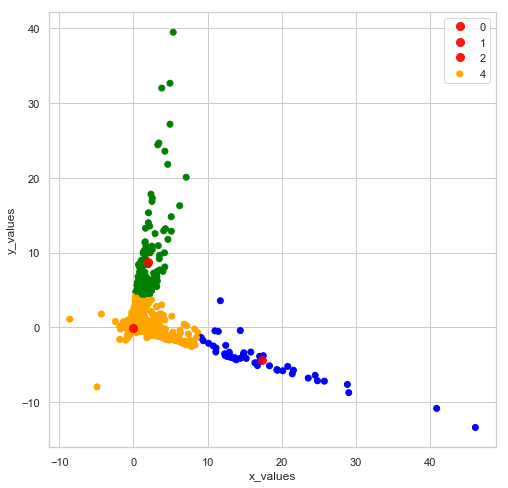

In [22]:
tocluster = pd.DataFrame(ps[[3,4]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[3],tocluster[4],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [23]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()


In [24]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.396799
170155,0.229212
170080,0.228942
179549,0.226415
179437,0.209097
170134,0.164252
179438,0.153538
170039,0.141644
170054,0.130660


In [25]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179797,2.851064
170105,2.000000
170054,1.000000
179854,0.617021
170134,0.595745
179799,0.595745
179548,0.510638
179846,0.468085
179850,0.425532


In [26]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179549,1.250000
170134,1.191176
170157,1.066176
170155,0.676471
271025,0.676471
179548,0.566176
270591,0.558824
170080,0.544118
179437,0.544118


In [24]:
# print (c_preds[0:100])

['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


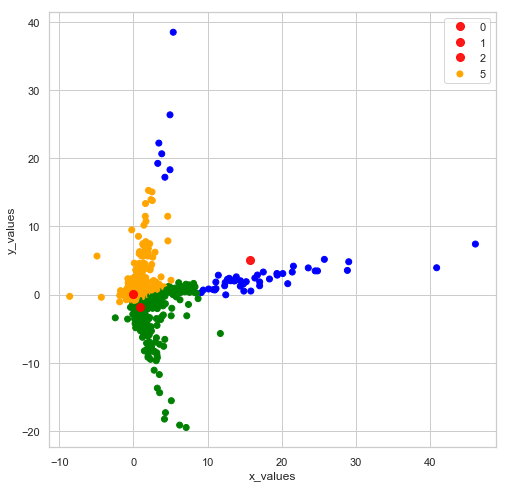

In [27]:
tocluster = pd.DataFrame(ps[[3,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[3],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [28]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [29]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.371713
170155,0.211425
170080,0.203050
179437,0.200984
179549,0.195211
179438,0.147174
170134,0.132991
170039,0.130532
170132,0.111610


In [30]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179797,2.509434
170105,1.773585
170054,0.905660
170134,0.886792
179854,0.547170
179799,0.509434
179846,0.415094
179548,0.396226
179850,0.358491


In [31]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.848970
179549,0.807780
170054,0.750000
170134,0.735698
170080,0.668764
170155,0.550343
179548,0.491419
170132,0.407895
270591,0.398169


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


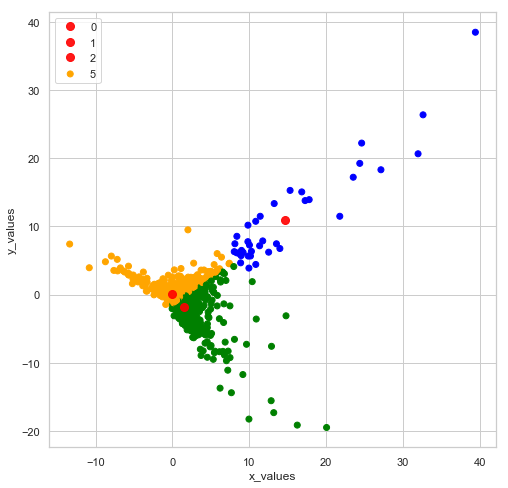

In [32]:
tocluster = pd.DataFrame(ps[[4,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [33]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [34]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.369192
170155,0.208484
170080,0.206143
179437,0.200184
179549,0.198801
179438,0.147336
170134,0.135774
170039,0.131198
170132,0.111549


In [35]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
179333,1.421053
170157,1.131579
271025,1.131579
270965,0.947368
170134,0.842105
270964,0.526316
270874,0.473684
270924,0.421053
270780,0.394737


In [36]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.904353
179549,0.787860
170134,0.738811
170054,0.687922
170080,0.650521
170155,0.624770
179548,0.438994
270591,0.438994
170132,0.429185
